In [1]:
# # This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')

# # TODO: Enter the foldername in your Drive where you have saved the unzipped
# # assignment folder, e.g. 'cs6353/assignments/assignment1/'
# FOLDERNAME = 'assignment1'
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# # Now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# # This downloads the CIFAR-10 dataset to your Drive
# # if it doesn't already exist.
# %cd /content/drive/My\ Drive/$FOLDERNAME/cs6353/datasets/
# !bash get_datasets.sh
# %cd /content/drive/My\ Drive/$FOLDERNAME

# # Install requirements from colab_requirements.txt
# # TODO: Please change your path below to the colab_requirements.txt file
# ! python -m pip install -r /content/drive/My\ Drive/$FOLDERNAME/colab_requirements.txt

# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://utah.instructure.com/courses/919972/assignments/12590082) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
from __future__ import print_function
import random
import numpy as np
from cs6353.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs6353/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs6353/classifiers/softmax.py**. 


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs6353/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs6353.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.398060
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** 
Because for the weights without gradient descent, it can be roughly estimated that the probability of selecting each category is 1/10, so the probability of selecting the correct category is 1/10. The loss function can be expressed as 1/N * sigma (-log (1 /10)), its value is -log(0.1).

In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs6353.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.672178 analytic: -0.672178, relative error: 4.682864e-08
numerical: 6.184807 analytic: 6.184807, relative error: 1.222230e-08
numerical: 0.186668 analytic: 0.186668, relative error: 1.368333e-08
numerical: -1.766186 analytic: -1.766186, relative error: 3.407252e-08
numerical: -3.437839 analytic: -3.437839, relative error: 2.103722e-08
numerical: -2.310615 analytic: -2.310615, relative error: 7.520068e-09
numerical: -0.041020 analytic: -0.041020, relative error: 2.381192e-07
numerical: -2.044117 analytic: -2.044117, relative error: 1.198714e-08
numerical: -0.944077 analytic: -0.944077, relative error: 8.487483e-09
numerical: -0.915686 analytic: -0.915686, relative error: 6.271561e-08
numerical: 0.622275 analytic: 0.622275, relative error: 4.265229e-08
numerical: -2.839514 analytic: -2.839514, relative error: 4.901588e-09
numerical: 0.842350 analytic: 0.842350, relative error: 7.881849e-08
numerical: 2.091051 analytic: 2.091051, relative error: 3.783442e-08
numerical: 1.650

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs6353.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.398060e+00 computed in 0.049833s
vectorized loss: 2.398060e+00 computed in 0.001995s
Loss difference: 0.000000
Gradient difference: 0.000000


In [7]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs6353.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = np.linspace(8e-8, 1e-6, 10)
regularization_strengths = np.linspace(1.5e4, 4e4, 10)
# learning_rates = [1e-7, 5e-7]
# regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifier in best_softmax.                          #
################################################################################

for learn in learning_rates:
    for regular in regularization_strengths:
        new_softmax = Softmax()
        new_softmax.train(X_train, y_train, learn, regular, num_iters=1500, verbose=True)
        y_train_pred = new_softmax.predict(X_train)
        y_val_pred = new_softmax.predict(X_val)
        train_acc = np.mean(y_train == y_train_pred)
        val_acc = np.mean(y_val == y_val_pred)
        if best_val < val_acc:
            best_val = val_acc
            best_softmax = new_softmax
        results[(learn, regular)] = (train_acc, val_acc)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 464.768182
iteration 100 / 1500: loss 286.698064
iteration 200 / 1500: loss 177.403418
iteration 300 / 1500: loss 110.294864
iteration 400 / 1500: loss 69.049094
iteration 500 / 1500: loss 43.236798
iteration 600 / 1500: loss 27.565002
iteration 700 / 1500: loss 17.752926
iteration 800 / 1500: loss 11.722581
iteration 900 / 1500: loss 8.017363
iteration 1000 / 1500: loss 5.702425
iteration 1100 / 1500: loss 4.319076
iteration 1200 / 1500: loss 3.529038
iteration 1300 / 1500: loss 2.914610
iteration 1400 / 1500: loss 2.609000
iteration 0 / 1500: loss 554.824261
iteration 100 / 1500: loss 313.484443
iteration 200 / 1500: loss 177.729218
iteration 300 / 1500: loss 101.170909
iteration 400 / 1500: loss 58.176490
iteration 500 / 1500: loss 33.683133
iteration 600 / 1500: loss 19.899195
iteration 700 / 1500: loss 12.156976
iteration 800 / 1500: loss 7.766400
iteration 900 / 1500: loss 5.292095
iteration 1000 / 1500: loss 3.828682
iteration 1100 / 1500: loss 3.187020


iteration 1300 / 1500: loss 2.121482
iteration 1400 / 1500: loss 2.043491
iteration 0 / 1500: loss 890.732222
iteration 100 / 1500: loss 108.291266
iteration 200 / 1500: loss 14.814257
iteration 300 / 1500: loss 3.576812
iteration 400 / 1500: loss 2.296516
iteration 500 / 1500: loss 2.096252
iteration 600 / 1500: loss 2.106150
iteration 700 / 1500: loss 2.117343
iteration 800 / 1500: loss 2.092747
iteration 900 / 1500: loss 2.067513
iteration 1000 / 1500: loss 2.100020
iteration 1100 / 1500: loss 2.078335
iteration 1200 / 1500: loss 2.062025
iteration 1300 / 1500: loss 2.084377
iteration 1400 / 1500: loss 2.131117
iteration 0 / 1500: loss 986.392180
iteration 100 / 1500: loss 98.027497
iteration 200 / 1500: loss 11.487112
iteration 300 / 1500: loss 3.033591
iteration 400 / 1500: loss 2.184153
iteration 500 / 1500: loss 2.070350
iteration 600 / 1500: loss 2.139172
iteration 700 / 1500: loss 2.062363
iteration 800 / 1500: loss 2.071719
iteration 900 / 1500: loss 2.189918
iteration 1000 /

iteration 1300 / 1500: loss 2.168366
iteration 1400 / 1500: loss 2.049158
iteration 0 / 1500: loss 470.937590
iteration 100 / 1500: loss 46.928237
iteration 200 / 1500: loss 6.396279
iteration 300 / 1500: loss 2.455553
iteration 400 / 1500: loss 2.119907
iteration 500 / 1500: loss 1.952391
iteration 600 / 1500: loss 2.022013
iteration 700 / 1500: loss 2.010234
iteration 800 / 1500: loss 2.094656
iteration 900 / 1500: loss 2.035679
iteration 1000 / 1500: loss 2.021630
iteration 1100 / 1500: loss 2.071714
iteration 1200 / 1500: loss 2.024700
iteration 1300 / 1500: loss 2.136598
iteration 1400 / 1500: loss 2.007162
iteration 0 / 1500: loss 549.876047
iteration 100 / 1500: loss 36.002793
iteration 200 / 1500: loss 4.203977
iteration 300 / 1500: loss 2.190259
iteration 400 / 1500: loss 2.026568
iteration 500 / 1500: loss 2.038096
iteration 600 / 1500: loss 2.055346
iteration 700 / 1500: loss 2.023571
iteration 800 / 1500: loss 2.097440
iteration 900 / 1500: loss 2.101311
iteration 1000 / 15

iteration 1400 / 1500: loss 2.055519
iteration 0 / 1500: loss 894.486644
iteration 100 / 1500: loss 4.975341
iteration 200 / 1500: loss 2.108216
iteration 300 / 1500: loss 2.093042
iteration 400 / 1500: loss 2.180978
iteration 500 / 1500: loss 2.144893
iteration 600 / 1500: loss 2.036163
iteration 700 / 1500: loss 2.088981
iteration 800 / 1500: loss 2.150793
iteration 900 / 1500: loss 2.112445
iteration 1000 / 1500: loss 2.127795
iteration 1100 / 1500: loss 2.110780
iteration 1200 / 1500: loss 2.137803
iteration 1300 / 1500: loss 2.099983
iteration 1400 / 1500: loss 2.047363
iteration 0 / 1500: loss 986.558341
iteration 100 / 1500: loss 3.934446
iteration 200 / 1500: loss 2.087829
iteration 300 / 1500: loss 2.183311
iteration 400 / 1500: loss 2.072661
iteration 500 / 1500: loss 2.142291
iteration 600 / 1500: loss 2.066415
iteration 700 / 1500: loss 2.103836
iteration 800 / 1500: loss 2.124405
iteration 900 / 1500: loss 2.091375
iteration 1000 / 1500: loss 2.142421
iteration 1100 / 1500

iteration 0 / 1500: loss 466.105810
iteration 100 / 1500: loss 8.870576
iteration 200 / 1500: loss 2.184462
iteration 300 / 1500: loss 2.056609
iteration 400 / 1500: loss 2.069455
iteration 500 / 1500: loss 2.044986
iteration 600 / 1500: loss 1.983023
iteration 700 / 1500: loss 2.050641
iteration 800 / 1500: loss 2.082967
iteration 900 / 1500: loss 2.060668
iteration 1000 / 1500: loss 2.074452
iteration 1100 / 1500: loss 2.044638
iteration 1200 / 1500: loss 1.982562
iteration 1300 / 1500: loss 1.996934
iteration 1400 / 1500: loss 2.029978
iteration 0 / 1500: loss 554.937691
iteration 100 / 1500: loss 5.797895
iteration 200 / 1500: loss 2.163053
iteration 300 / 1500: loss 2.114743
iteration 400 / 1500: loss 2.049452
iteration 500 / 1500: loss 2.096755
iteration 600 / 1500: loss 2.065586
iteration 700 / 1500: loss 1.983859
iteration 800 / 1500: loss 2.102799
iteration 900 / 1500: loss 2.096293
iteration 1000 / 1500: loss 2.054803
iteration 1100 / 1500: loss 2.068833
iteration 1200 / 1500

iteration 100 / 1500: loss 2.226085
iteration 200 / 1500: loss 2.123615
iteration 300 / 1500: loss 2.129464
iteration 400 / 1500: loss 2.079126
iteration 500 / 1500: loss 2.064320
iteration 600 / 1500: loss 2.093638
iteration 700 / 1500: loss 2.153648
iteration 800 / 1500: loss 2.150737
iteration 900 / 1500: loss 2.101615
iteration 1000 / 1500: loss 2.067045
iteration 1100 / 1500: loss 2.107193
iteration 1200 / 1500: loss 2.141119
iteration 1300 / 1500: loss 2.107476
iteration 1400 / 1500: loss 2.107766
iteration 0 / 1500: loss 975.160127
iteration 100 / 1500: loss 2.170841
iteration 200 / 1500: loss 2.081013
iteration 300 / 1500: loss 2.082717
iteration 400 / 1500: loss 2.093519
iteration 500 / 1500: loss 2.216109
iteration 600 / 1500: loss 2.114383
iteration 700 / 1500: loss 2.114413
iteration 800 / 1500: loss 2.135828
iteration 900 / 1500: loss 2.151438
iteration 1000 / 1500: loss 2.085303
iteration 1100 / 1500: loss 2.120017
iteration 1200 / 1500: loss 2.109237
iteration 1300 / 150

iteration 200 / 1500: loss 2.047183
iteration 300 / 1500: loss 2.126848
iteration 400 / 1500: loss 2.126112
iteration 500 / 1500: loss 2.108552
iteration 600 / 1500: loss 2.032445
iteration 700 / 1500: loss 2.019633
iteration 800 / 1500: loss 1.997095
iteration 900 / 1500: loss 2.040159
iteration 1000 / 1500: loss 2.065858
iteration 1100 / 1500: loss 2.055456
iteration 1200 / 1500: loss 2.073238
iteration 1300 / 1500: loss 2.012458
iteration 1400 / 1500: loss 2.058727
iteration 0 / 1500: loss 550.999632
iteration 100 / 1500: loss 2.441205
iteration 200 / 1500: loss 1.964674
iteration 300 / 1500: loss 2.093344
iteration 400 / 1500: loss 2.083172
iteration 500 / 1500: loss 2.065520
iteration 600 / 1500: loss 2.010713
iteration 700 / 1500: loss 2.112156
iteration 800 / 1500: loss 2.105747
iteration 900 / 1500: loss 2.063571
iteration 1000 / 1500: loss 2.097460
iteration 1100 / 1500: loss 2.096861
iteration 1200 / 1500: loss 2.057498
iteration 1300 / 1500: loss 2.067781
iteration 1400 / 15

In [8]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.352000


**Inline Question** - *True or False*

It's possible to add a new data point to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: 
True

*Your explanation*:
The loss calculated in SVM only considers categories that do not have a score lower than the correct category score Δ, so adding new data points will not change the loss as long as the score of the wrong category is lower than the score Δ of the correct category. But softmax is different. Adding new data points means reducing the score of the correct category, and the loss function of softmax is associated with the relationship between the correct category and the total score, so the loss will change.

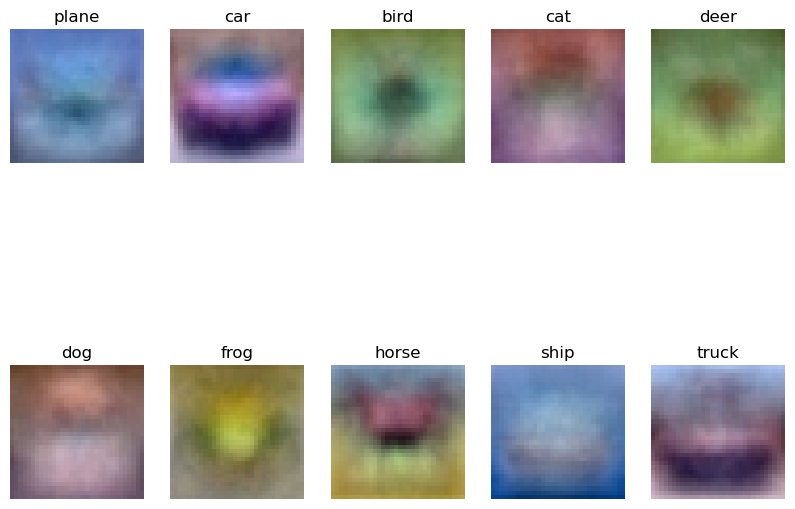

In [9]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])